# Test estimating initial conditions and transition matrix
## Scenario 1: Use True Parameters

In [16]:
import numpy as np


def make_transition_from_diag(diag):
    n_states = len(diag)
    transition_matrix = diag * np.eye(n_states)
    off_diag = ((1.0 - diag) / (n_states - 1.0))[:, np.newaxis]
    transition_matrix += np.ones((n_states, n_states)) * off_diag - off_diag * np.eye(
        n_states
    )

    return transition_matrix

array([[0.968, 0.016, 0.016],
       [0.01 , 0.98 , 0.01 ],
       [0.016, 0.016, 0.968]])

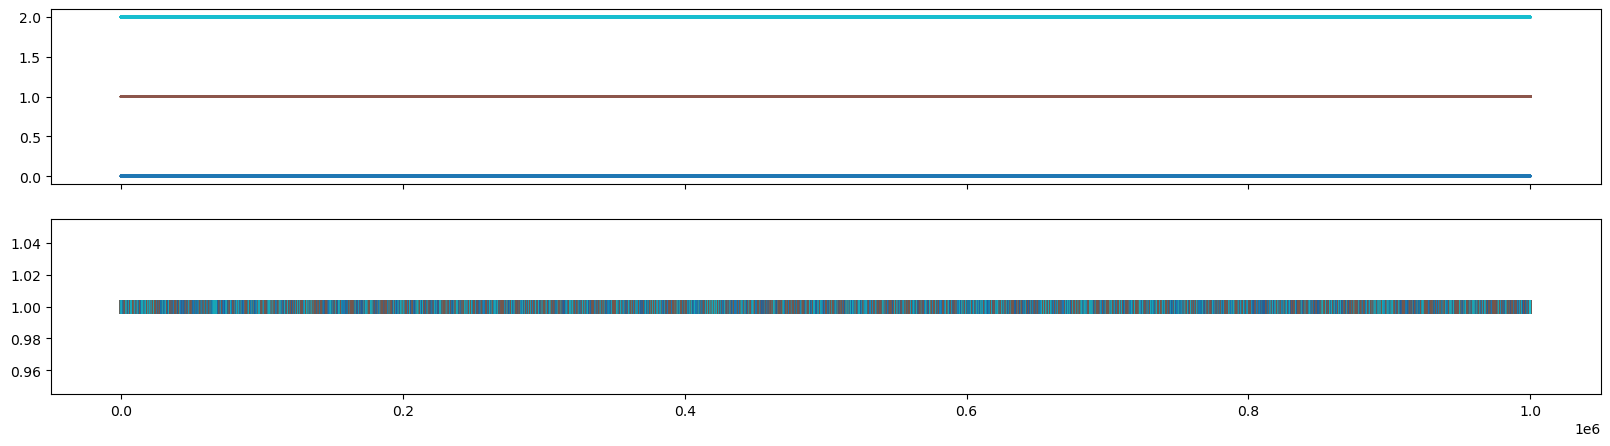

In [1]:
from hmmlearn import hmm
import matplotlib.pyplot as plt

sampling_rate = 1
n_time = 1_000_000

# Build an HMM instance and set parameters
model = hmm.PoissonHMM(n_components=3, init_params="", params="")

diag = np.array([0.968, 0.98, 0.968])

transition_matrix = make_transition_from_diag(diag)

initial_conditions = np.array([0.99, 0.005, 0.005])

model.startprob_ = initial_conditions
model.transmat_ = transition_matrix
model.lambdas_ = np.array([10.0, 20.0, 40.0])[:, np.newaxis] / sampling_rate


time = np.arange(n_time) / sampling_rate
spikes, latent_states = model.sample(n_time)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 5))
axes[0].scatter(time, latent_states, c=latent_states, cmap="tab10", s=1)

spike_time_ind = np.nonzero(spikes)[0]
axes[1].scatter(
    time[spike_time_ind],
    np.ones((len(spike_time_ind),)),
    c=latent_states[spike_time_ind],
    cmap="tab10",
    s=100,
    marker="|",
)

In [2]:
from src.hmm import forward, smoother, viterbi
import scipy.stats

log_likelihood = scipy.stats.poisson.logpmf(spikes, model.lambdas_.T)

causal_posterior, predictive_distribution, marginal_likelihood = forward(
    initial_conditions=initial_conditions,
    log_likelihood=log_likelihood,
    transition_matrix=transition_matrix,
)

acausal_posterior = smoother(
    causal_posterior, predictive_distribution, transition_matrix
)

predicted_states, path_probability = viterbi(
    initial_conditions=initial_conditions,
    log_likelihood=log_likelihood,
    transition_matrix=transition_matrix,
)

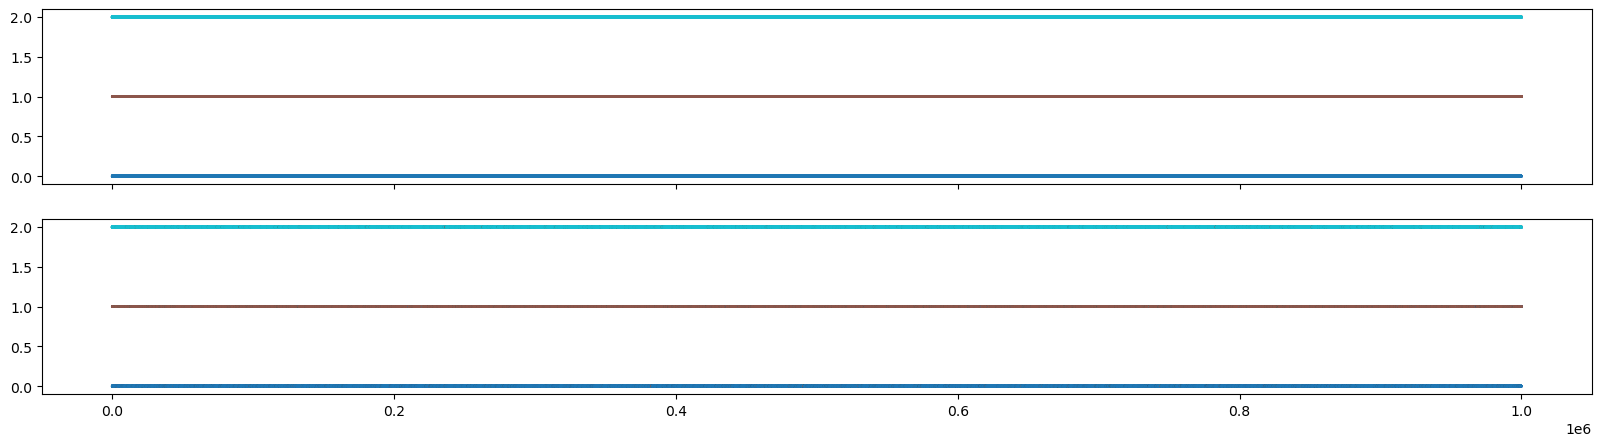

In [3]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 5))
axes[0].scatter(time, latent_states, c=latent_states, cmap="tab10", s=1)

axes[1].scatter(time, predicted_states, c=latent_states, cmap="tab10", s=1)

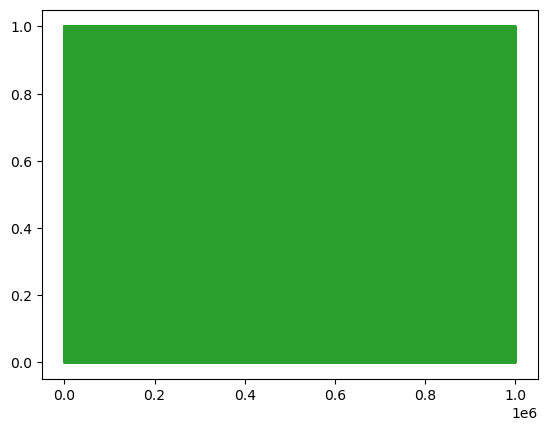

In [4]:
plt.plot(time, acausal_posterior)

In [5]:
np.allclose(acausal_posterior, model.predict_proba(spikes))

True

In [6]:
np.allclose(predicted_states, model.predict(spikes))

True

In [15]:
np.allclose(model.score(spikes), marginal_likelihood)

True

## Scenario #2: Use Estimated Parameters

In [34]:
from src.hmm import (
    estimate_parameters_via_em,
    check_converged,
    estimate_initial_conditions,
)
from src.estimate_transition import estimate_stationary_state_transition

max_iter = 100
tolerance = 1e-4
marginal_log_likelihoods = []
n_iter = 0
converged = False


estimated_initial_conditions = np.array([0.99, 0.005, 0.005])

diag = np.array([0.99, 0.99, 0.99])
estimated_transition_matrix = make_transition_from_diag(diag)


while not converged and (n_iter < max_iter):
    # estimated_initial_conditions, estimated_transition_matrix, acausal_posterior, marginal_log_likelihood = estimate_parameters_via_em(
    #     estimated_initial_conditions,
    #     log_likelihood,
    #     estimated_transition_matrix,
    # )

    # Expectation
    print("Expectation")
    causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
        estimated_initial_conditions, log_likelihood, estimated_transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, estimated_transition_matrix
    )

    # Maximization
    print("Maximization")
    estimated_initial_conditions = estimate_initial_conditions(acausal_posterior)
    estimated_transition_matrix = estimate_stationary_state_transition(
        causal_posterior,
        predictive_distribution,
        estimated_transition_matrix,
        acausal_posterior,
    )

    # Stats
    print("Stats")
    n_iter += 1

    marginal_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = (
            marginal_log_likelihoods[-1] - marginal_log_likelihoods[-2]
        )
        converged, _ = check_converged(
            marginal_log_likelihoods[-1], marginal_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, likelihood: {marginal_log_likelihoods[-1]}")

Expectation
Maximization
Stats
Expectation
Maximization
Stats
iteration 2, likelihood: -3042604.9671418155, change: 9942.011729221791
Expectation
Maximization
Stats
iteration 3, likelihood: -3042581.671326617, change: 23.29581519868225


In [35]:
estimated_transition_matrix

array([[0.96788353, 0.01615816, 0.01595832],
       [0.01008998, 0.9799035 , 0.01000652],
       [0.01594812, 0.01645696, 0.96759492]])

In [36]:
model.transmat_

array([[0.968, 0.016, 0.016],
       [0.01 , 0.98 , 0.01 ],
       [0.016, 0.016, 0.968]])

In [37]:
np.allclose(model.transmat_, estimated_transition_matrix, atol=1e-3)

True

In [38]:
model.startprob_

array([0.99 , 0.005, 0.005])

In [39]:
estimated_initial_conditions

array([1.00000000e+00, 2.21308147e-10, 1.69837316e-24])

## Scenario #3: Estimate Parameters using Non-Stationary Transition Matrix

In [45]:
from src.hmm import (
    check_converged,
    estimate_initial_conditions,
    forward,
    smoother,
)
from src.estimate_transition import estimate_non_stationary_state_transition
from src.hmm import centered_softmax_inverse
from patsy import dmatrix

max_iter = 100
tolerance = 1e-4
marginal_log_likelihoods = []
n_iter = 0
converged = False


estimated_initial_conditions = np.array([0.99, 0.005, 0.005])

diag = np.array([0.99, 0.99, 0.99])
estimated_transition_matrix = make_transition_from_diag(diag)
# if any is zero, set to small number
estimated_transition_matrix = np.clip(
    estimated_transition_matrix, a_min=1e-16, a_max=1.0 - 1e-16
)
estimated_transition_matrix /= estimated_transition_matrix.sum(axis=1, keepdims=True)
n_states = estimated_transition_matrix.shape[0]

# formula = f"1"
# data = {}
# transition_design_matrix = dmatrix(formula, data)
transition_design_matrix = np.ones((n_time, 1))

n_time, n_coefficients = transition_design_matrix.shape

transition_coefficients = np.zeros((n_coefficients, n_states, n_states - 1))
transition_coefficients[0] = centered_softmax_inverse(estimated_transition_matrix)

estimated_transition_matrix = estimated_transition_matrix[np.newaxis] * np.ones(
    (n_time, n_states, n_states)
)


while not converged and (n_iter < max_iter):
    # Expectation
    print("Expectation")
    causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
        estimated_initial_conditions, log_likelihood, estimated_transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, estimated_transition_matrix
    )

    # Maximization
    print("Maximization")
    estimated_initial_conditions = estimate_initial_conditions(acausal_posterior)
    (
        transition_coefficients,
        estimated_transition_matrix,
    ) = estimate_non_stationary_state_transition(
        transition_coefficients,
        transition_design_matrix,
        causal_posterior,
        predictive_distribution,
        estimated_transition_matrix,
        acausal_posterior,
        disp=True,
    )

    # Stats
    print("Stats")
    n_iter += 1

    marginal_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = (
            marginal_log_likelihoods[-1] - marginal_log_likelihoods[-2]
        )
        converged, _ = check_converged(
            marginal_log_likelihoods[-1], marginal_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, likelihood: {marginal_log_likelihoods[-1]}")

Expectation
Maximization
Optimization terminated successfully.
         Current function value: 0.043985
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 5
         Current function value: 0.048463
         Iterations: 4
         Function evaluations: 138
         Gradient evaluations: 123
         Hessian evaluations: 5
Optimization terminated successfully.
         Current function value: 0.044837
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
         Hessian evaluations: 4
Stats
iteration 1, likelihood: -3052546.9788710373
Expectation
Maximization
Optimization terminated successfully.
         Current function value: 0.045399
         Iterations: 3
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 3
Optimization terminated successfully.
         Current function value: 0.050145
         Iterations: 3
         Function evaluati

In [51]:
model.transmat_

array([[0.968, 0.016, 0.016],
       [0.01 , 0.98 , 0.01 ],
       [0.016, 0.016, 0.968]])

In [50]:
estimated_transition_matrix[0]

array([[0.96788323, 0.01615852, 0.01595834],
       [0.01008996, 0.97990364, 0.01000642],
       [0.01594885, 0.01645692, 0.96759427]])

In [49]:
np.allclose(estimated_transition_matrix[0], model.transmat_, atol=1e-3)

True

In [53]:
estimated_initial_conditions

array([1.00000000e+00, 2.21377136e-10, 1.69818754e-24])

## Scenario #4: Estimate Non-Stationary Transition Matrix with Non-Stationary Model

In [54]:
# Build an HMM instance and set parameters
model2 = hmm.PoissonHMM(n_components=3, init_params="", params="")

diag2 = np.array([0.98, 0.968, 0.98])

transition_matrix2 = make_transition_from_diag(diag2)

initial_conditions2 = np.array([0.99, 0.005, 0.005])

model2.startprob_ = initial_conditions2
model2.transmat_ = transition_matrix2
model2.lambdas_ = np.array([10.0, 20.0, 40.0])[:, np.newaxis] / sampling_rate


time2 = np.arange(n_time) / sampling_rate
spikes2, latent_states2 = model2.sample(n_time)

In [55]:
spikes3 = np.concatenate((spikes, spikes2))
latent_states3 = np.concatenate((latent_states, latent_states2))

In [56]:
log_likelihood3 = scipy.stats.poisson.logpmf(spikes3, model.lambdas_.T)

In [59]:
second_half = np.zeros((len(spikes3)), dtype=bool)
second_half[len(spikes3) // 2 :] = True
second_half

array([False, False, False, ...,  True,  True,  True])

In [60]:
from src.hmm import (
    check_converged,
    estimate_initial_conditions,
    forward,
    smoother,
)
from src.estimate_transition import estimate_non_stationary_state_transition
from src.hmm import centered_softmax_inverse
from patsy import dmatrix

max_iter = 100
tolerance = 1e-4
marginal_log_likelihoods = []
n_iter = 0
converged = False


estimated_initial_conditions = np.array([0.99, 0.005, 0.005])

diag = np.array([0.99, 0.99, 0.99])
estimated_transition_matrix = make_transition_from_diag(diag)
# if any is zero, set to small number
estimated_transition_matrix = np.clip(
    estimated_transition_matrix, a_min=1e-16, a_max=1.0 - 1e-16
)
estimated_transition_matrix /= estimated_transition_matrix.sum(axis=1, keepdims=True)
n_states = estimated_transition_matrix.shape[0]

formula = f"1 + second_half"
data = {"second_half": second_half}
transition_design_matrix = dmatrix(formula, data)

n_time, n_coefficients = transition_design_matrix.shape

transition_coefficients = np.zeros((n_coefficients, n_states, n_states - 1))
transition_coefficients[0] = centered_softmax_inverse(estimated_transition_matrix)

estimated_transition_matrix = estimated_transition_matrix[np.newaxis] * np.ones(
    (n_time, n_states, n_states)
)


while not converged and (n_iter < max_iter):
    # Expectation
    print("Expectation")
    causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
        estimated_initial_conditions, log_likelihood3, estimated_transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, estimated_transition_matrix
    )

    # Maximization
    print("Maximization")
    estimated_initial_conditions = estimate_initial_conditions(acausal_posterior)
    (
        transition_coefficients,
        estimated_transition_matrix,
    ) = estimate_non_stationary_state_transition(
        transition_coefficients,
        transition_design_matrix,
        causal_posterior,
        predictive_distribution,
        estimated_transition_matrix,
        acausal_posterior,
        disp=True,
    )

    # Stats
    print("Stats")
    n_iter += 1

    marginal_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = (
            marginal_log_likelihoods[-1] - marginal_log_likelihoods[-2]
        )
        converged, _ = check_converged(
            marginal_log_likelihoods[-1], marginal_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, likelihood: {marginal_log_likelihoods[-1]}")

Expectation
Maximization
Optimization terminated successfully.
         Current function value: 0.042639
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 5
Optimization terminated successfully.
         Current function value: 0.043117
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 5
Optimization terminated successfully.
         Current function value: 0.043646
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 5
Stats
iteration 1, likelihood: -6092385.49614367
Expectation
Maximization
Optimization terminated successfully.
         Current function value: 0.043855
         Iterations: 3
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 3
Optimization terminated successfully.
         Current function value: 0.044723
         Iteratio

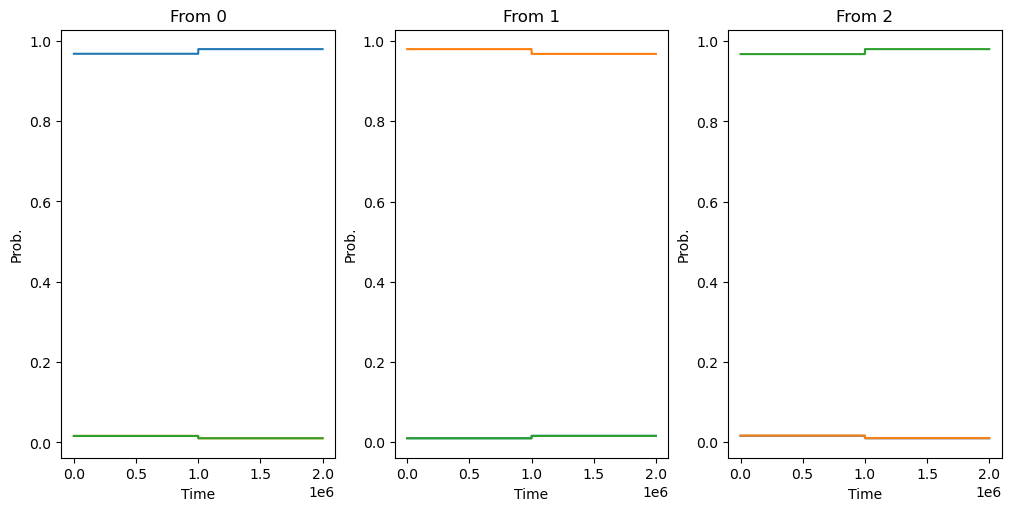

In [62]:
from src.hmm import centered_softmax_forward

fig, axes = plt.subplots(
    1, n_states, sharex=True, constrained_layout=True, figsize=(10, 5)
)

for from_state_ind, ax in enumerate(axes.flat):
    from_local_transition = centered_softmax_forward(
        transition_design_matrix @ transition_coefficients[:, from_state_ind]
    )

    ax.plot(
        np.arange(estimated_transition_matrix.shape[0]) / sampling_rate,
        from_local_transition,
    )
    ax.set_xlabel("Time")
    ax.set_ylabel("Prob.")
    ax.set_title(f"From {from_state_ind}")

In [63]:
estimated_transition_matrix[0]

array([[0.96794689, 0.01615543, 0.01589768],
       [0.01008408, 0.97985566, 0.01006035],
       [0.01588442, 0.01637412, 0.96774149]])

In [64]:
model.transmat_

array([[0.968, 0.016, 0.016],
       [0.01 , 0.98 , 0.01 ],
       [0.016, 0.016, 0.968]])

In [65]:
estimated_transition_matrix[-1]

array([[0.97952396, 0.0102093 , 0.01026671],
       [0.01612853, 0.96794075, 0.01593075],
       [0.00972148, 0.01014666, 0.9801318 ]])

In [66]:
model2.transmat_

array([[0.98 , 0.01 , 0.01 ],
       [0.016, 0.968, 0.016],
       [0.01 , 0.01 , 0.98 ]])

In [67]:
initial_conditions

array([9.99999893e-01, 1.06634124e-07, 5.45080460e-17])

### Scenario #5: Estimate using splines over time instead of an indicator

In [69]:
from src.hmm import (
    check_converged,
    estimate_initial_conditions,
    forward,
    smoother,
)
from src.estimate_transition import estimate_non_stationary_state_transition
from src.hmm import centered_softmax_inverse
from patsy import dmatrix

max_iter = 100
tolerance = 1e-4
marginal_log_likelihoods = []
n_iter = 0
converged = False


estimated_initial_conditions = np.array([0.99, 0.005, 0.005])

diag = np.array([0.99, 0.99, 0.99])
estimated_transition_matrix = make_transition_from_diag(diag)
# if any is zero, set to small number
estimated_transition_matrix = np.clip(
    estimated_transition_matrix, a_min=1e-16, a_max=1.0 - 1e-16
)
estimated_transition_matrix /= estimated_transition_matrix.sum(axis=1, keepdims=True)
n_states = estimated_transition_matrix.shape[0]

time3 = np.arange(len(log_likelihood3)) / sampling_rate

formula = f"1 + bs(time, df=3)"
data = {"time": time3}
transition_design_matrix = dmatrix(formula, data)

n_time, n_coefficients = transition_design_matrix.shape

transition_coefficients = np.zeros((n_coefficients, n_states, n_states - 1))
transition_coefficients[0] = centered_softmax_inverse(estimated_transition_matrix)

estimated_transition_matrix = estimated_transition_matrix[np.newaxis] * np.ones(
    (n_time, n_states, n_states)
)


while not converged and (n_iter < max_iter):
    # Expectation
    print("Expectation")
    causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
        estimated_initial_conditions, log_likelihood3, estimated_transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, estimated_transition_matrix
    )

    # Maximization
    print("Maximization")
    estimated_initial_conditions = estimate_initial_conditions(acausal_posterior)
    (
        transition_coefficients,
        estimated_transition_matrix,
    ) = estimate_non_stationary_state_transition(
        transition_coefficients,
        transition_design_matrix,
        causal_posterior,
        predictive_distribution,
        estimated_transition_matrix,
        acausal_posterior,
        disp=True,
    )

    # Stats
    print("Stats")
    n_iter += 1

    marginal_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = (
            marginal_log_likelihoods[-1] - marginal_log_likelihoods[-2]
        )
        converged, _ = check_converged(
            marginal_log_likelihoods[-1], marginal_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, likelihood: {marginal_log_likelihoods[-1]}")

Expectation
Maximization
Optimization terminated successfully.
         Current function value: 0.042675
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 6
Optimization terminated successfully.
         Current function value: 0.043154
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 6
Optimization terminated successfully.
         Current function value: 0.043690
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 5
Stats
iteration 1, likelihood: -6092385.49614367
Expectation
Maximization
Optimization terminated successfully.
         Current function value: 0.043883
         Iterations: 3
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 3
Optimization terminated successfully.
         Current function value: 0.044747
         Iteratio

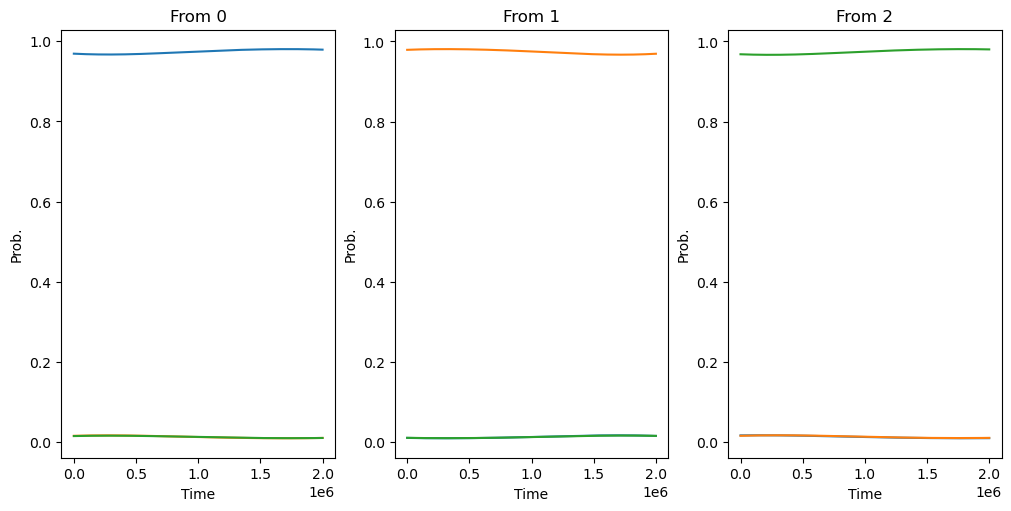

In [70]:
from src.hmm import centered_softmax_forward

fig, axes = plt.subplots(
    1, n_states, sharex=True, constrained_layout=True, figsize=(10, 5)
)

for from_state_ind, ax in enumerate(axes.flat):
    from_local_transition = centered_softmax_forward(
        transition_design_matrix @ transition_coefficients[:, from_state_ind]
    )

    ax.plot(
        np.arange(estimated_transition_matrix.shape[0]) / sampling_rate,
        from_local_transition,
    )
    ax.set_xlabel("Time")
    ax.set_ylabel("Prob.")
    ax.set_title(f"From {from_state_ind}")

## Scenario #5: Use no regularization on splines

In [71]:
from src.hmm import (
    check_converged,
    estimate_initial_conditions,
    forward,
    smoother,
)
from src.estimate_transition import estimate_non_stationary_state_transition
from src.hmm import centered_softmax_inverse
from patsy import dmatrix

max_iter = 100
tolerance = 1e-4
marginal_log_likelihoods = []
n_iter = 0
converged = False


estimated_initial_conditions = np.array([0.99, 0.005, 0.005])

diag = np.array([0.99, 0.99, 0.99])
estimated_transition_matrix = make_transition_from_diag(diag)
# if any is zero, set to small number
estimated_transition_matrix = np.clip(
    estimated_transition_matrix, a_min=1e-16, a_max=1.0 - 1e-16
)
estimated_transition_matrix /= estimated_transition_matrix.sum(axis=1, keepdims=True)
n_states = estimated_transition_matrix.shape[0]

time3 = np.arange(len(log_likelihood3)) / sampling_rate

formula = f"1 + bs(time, df=3)"
data = {"time": time3}
transition_design_matrix = dmatrix(formula, data)

n_time, n_coefficients = transition_design_matrix.shape

transition_coefficients = np.zeros((n_coefficients, n_states, n_states - 1))
transition_coefficients[0] = centered_softmax_inverse(estimated_transition_matrix)

estimated_transition_matrix = estimated_transition_matrix[np.newaxis] * np.ones(
    (n_time, n_states, n_states)
)


while not converged and (n_iter < max_iter):
    # Expectation
    print("Expectation")
    causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
        estimated_initial_conditions, log_likelihood3, estimated_transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, estimated_transition_matrix
    )

    # Maximization
    print("Maximization")
    estimated_initial_conditions = estimate_initial_conditions(acausal_posterior)
    (
        transition_coefficients,
        estimated_transition_matrix,
    ) = estimate_non_stationary_state_transition(
        transition_coefficients,
        transition_design_matrix,
        causal_posterior,
        predictive_distribution,
        estimated_transition_matrix,
        acausal_posterior,
        disp=True,
        transition_regularization=0.0,
    )

    # Stats
    print("Stats")
    n_iter += 1

    marginal_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = (
            marginal_log_likelihoods[-1] - marginal_log_likelihoods[-2]
        )
        converged, _ = check_converged(
            marginal_log_likelihoods[-1], marginal_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, likelihood: {marginal_log_likelihoods[-1]}")

Expectation
Maximization
Optimization terminated successfully.
         Current function value: 0.042667
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
         Hessian evaluations: 11
Optimization terminated successfully.
         Current function value: 0.043145
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 6
         Current function value: 0.043670
         Iterations: 4
         Function evaluations: 74
         Gradient evaluations: 62
         Hessian evaluations: 5
Stats
iteration 1, likelihood: -6092385.49614367
Expectation
Maximization
Optimization terminated successfully.
         Current function value: 0.043875
         Iterations: 3
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 3
Optimization terminated successfully.
         Current function value: 0.044740
         Iterations: 3
         Function evaluati

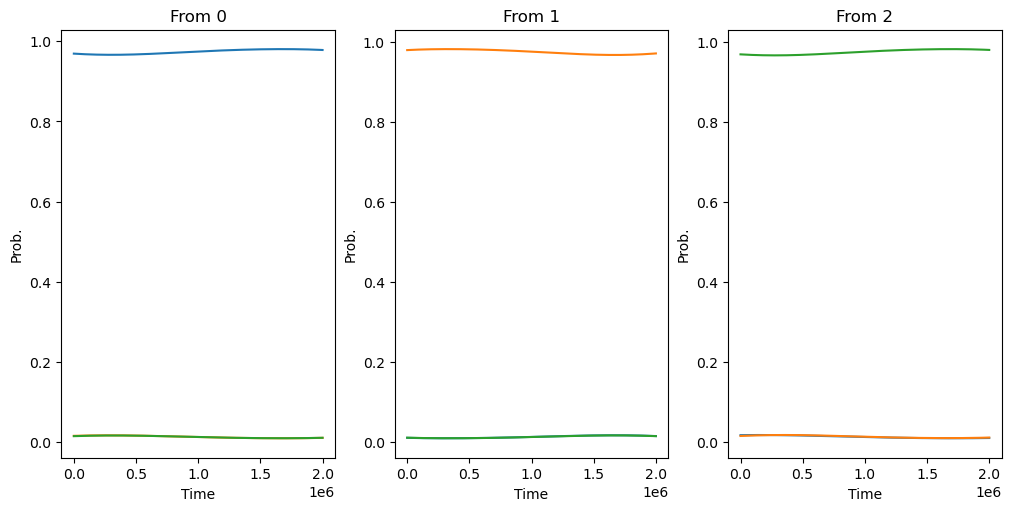

In [72]:
from src.hmm import centered_softmax_forward

fig, axes = plt.subplots(
    1, n_states, sharex=True, constrained_layout=True, figsize=(10, 5)
)

for from_state_ind, ax in enumerate(axes.flat):
    from_local_transition = centered_softmax_forward(
        transition_design_matrix @ transition_coefficients[:, from_state_ind]
    )

    ax.plot(
        np.arange(estimated_transition_matrix.shape[0]) / sampling_rate,
        from_local_transition,
    )
    ax.set_xlabel("Time")
    ax.set_ylabel("Prob.")
    ax.set_title(f"From {from_state_ind}")

## Scenario #6: Try different transition matrix

In [79]:
# Build an HMM instance and set parameters
model3 = hmm.PoissonHMM(n_components=3, init_params="", params="")

diag3 = np.array([0.98, 0.98, 0.80])

transition_matrix3 = make_transition_from_diag(diag3)

initial_conditions3 = np.array([0.99, 0.005, 0.005])

model3.startprob_ = initial_conditions3
model3.transmat_ = transition_matrix3
model3.lambdas_ = np.array([10.0, 20.0, 40.0])[:, np.newaxis] / sampling_rate


time3 = np.arange(n_time) / sampling_rate
spikes4, latent_states4 = model3.sample(n_time)

spikes4 = np.concatenate((spikes, spikes4))
latent_states4 = np.concatenate((latent_states, latent_states4))

log_likelihood4 = scipy.stats.poisson.logpmf(spikes4, model.lambdas_.T)

In [80]:
from src.hmm import (
    check_converged,
    estimate_initial_conditions,
    forward,
    smoother,
)
from src.estimate_transition import estimate_non_stationary_state_transition
from src.hmm import centered_softmax_inverse
from patsy import dmatrix

max_iter = 100
tolerance = 1e-4
marginal_log_likelihoods = []
n_iter = 0
converged = False


estimated_initial_conditions = np.array([0.99, 0.005, 0.005])

diag = np.array([0.99, 0.99, 0.99])
estimated_transition_matrix = make_transition_from_diag(diag)
# if any is zero, set to small number
estimated_transition_matrix = np.clip(
    estimated_transition_matrix, a_min=1e-16, a_max=1.0 - 1e-16
)
estimated_transition_matrix /= estimated_transition_matrix.sum(axis=1, keepdims=True)
n_states = estimated_transition_matrix.shape[0]

time4 = np.arange(len(log_likelihood4)) / sampling_rate

formula = f"1 + bs(time, df=3)"
data = {"time": time4}
transition_design_matrix = dmatrix(formula, data)

n_time, n_coefficients = transition_design_matrix.shape

transition_coefficients = np.zeros((n_coefficients, n_states, n_states - 1))
transition_coefficients[0] = centered_softmax_inverse(estimated_transition_matrix)

estimated_transition_matrix = estimated_transition_matrix[np.newaxis] * np.ones(
    (n_time, n_states, n_states)
)


while not converged and (n_iter < max_iter):
    # Expectation
    print("Expectation")
    causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
        estimated_initial_conditions, log_likelihood4, estimated_transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, estimated_transition_matrix
    )

    # Maximization
    print("Maximization")
    estimated_initial_conditions = estimate_initial_conditions(acausal_posterior)
    (
        transition_coefficients,
        estimated_transition_matrix,
    ) = estimate_non_stationary_state_transition(
        transition_coefficients,
        transition_design_matrix,
        causal_posterior,
        predictive_distribution,
        estimated_transition_matrix,
        acausal_posterior,
        disp=True,
    )

    # Stats
    print("Stats")
    n_iter += 1

    marginal_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = (
            marginal_log_likelihoods[-1] - marginal_log_likelihoods[-2]
        )
        converged, _ = check_converged(
            marginal_log_likelihoods[-1], marginal_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, likelihood: {marginal_log_likelihoods[-1]}")

Expectation
Maximization
Optimization terminated successfully.
         Current function value: 0.050046
         Iterations: 7
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 7
Optimization terminated successfully.
         Current function value: 0.049354
         Iterations: 6
         Function evaluations: 6
         Gradient evaluations: 6
         Hessian evaluations: 6
Optimization terminated successfully.
         Current function value: 0.033444
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 6
Stats
iteration 1, likelihood: -11778788.01387877
Expectation
Maximization
Optimization terminated successfully.
         Current function value: 0.051348
         Iterations: 3
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 3
Optimization terminated successfully.
         Current function value: 0.051788
         Iterati

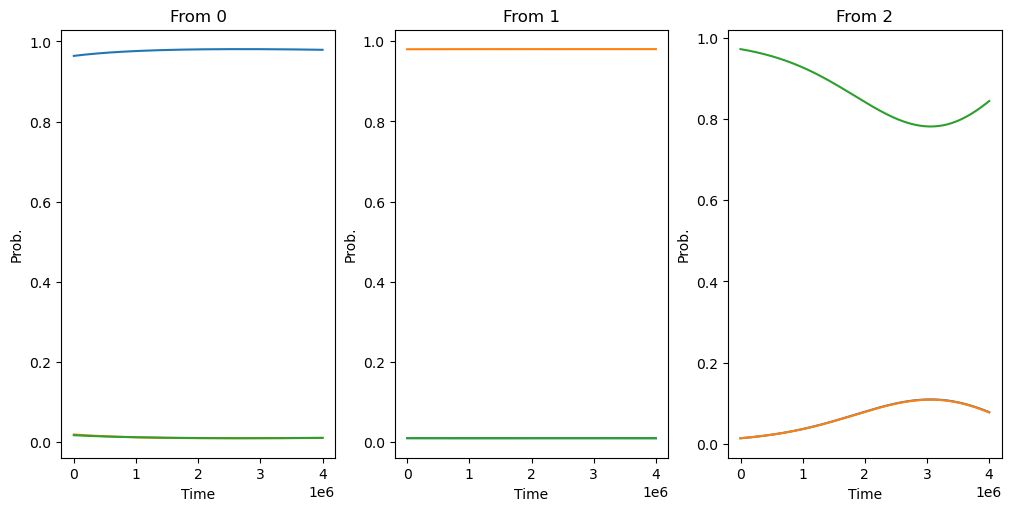

In [81]:
from src.hmm import centered_softmax_forward

fig, axes = plt.subplots(
    1, n_states, sharex=True, constrained_layout=True, figsize=(10, 5)
)

for from_state_ind, ax in enumerate(axes.flat):
    from_local_transition = centered_softmax_forward(
        transition_design_matrix @ transition_coefficients[:, from_state_ind]
    )

    ax.plot(
        np.arange(estimated_transition_matrix.shape[0]) / sampling_rate,
        from_local_transition,
    )
    ax.set_xlabel("Time")
    ax.set_ylabel("Prob.")
    ax.set_title(f"From {from_state_ind}")

In [82]:
estimated_transition_matrix[0]

array([[0.96383512, 0.01899502, 0.01716983],
       [0.01000185, 0.9798941 , 0.01010406],
       [0.01381768, 0.01397528, 0.97220707]])

In [83]:
estimated_transition_matrix[-1]

array([[0.97901642, 0.01040991, 0.01057371],
       [0.00999906, 0.98020536, 0.00979558],
       [0.07819264, 0.07747887, 0.84432852]])

# Test estimating emission

In [124]:
from src.simulate import (
    simulate_linear_distance_with_pauses,
    simulate_time,
    create_place_field,
    simulate_poisson_spikes,
)

track_height = 170
sampling_frequency = 1500
n_samples = sampling_frequency * 65

time = simulate_time(n_samples, sampling_frequency)
linear_distance = (
    simulate_linear_distance_with_pauses(
        time, track_height, sampling_frequency=sampling_frequency, pause=3
    )
    + np.random.randn(*time.shape) * 1e-4
)

place_field1 = create_place_field(50, linear_distance, sampling_frequency)
place_field2 = create_place_field(150, linear_distance, sampling_frequency)
spikes = np.concatenate(
    (
        simulate_poisson_spikes(place_field1, sampling_frequency).T,
        simulate_poisson_spikes(place_field2, sampling_frequency).T,
    )
).squeeze()

linear_distance = np.concatenate((linear_distance, linear_distance))

In [135]:
from src.hmm import (
    check_converged,
    estimate_initial_conditions,
    fit_poisson_regression,
)
from src.estimate_transition import estimate_stationary_state_transition

max_iter = 100
tolerance = 1e-4
marginal_log_likelihoods = []
n_iter = 0
converged = False


estimated_initial_conditions = np.array([0.99, 0.01])

diag = np.array([0.99, 0.99])
estimated_transition_matrix = make_transition_from_diag(diag)

emission_design_matrix = dmatrix("1 + bs(position, df=10)", {"position": linear_distance})

weights = np.random.randint(0, 2, size=spikes.shape[0])
emission_coefficients = np.stack(
    (fit_poisson_regression(design_matrix=emission_design_matrix, weights=(weights == 0).astype(float), spikes=spikes),
    fit_poisson_regression(design_matrix=emission_design_matrix, weights=(weights == 1).astype(float), spikes=spikes)),
    axis=0
)
conditional_intensity = np.exp(emission_design_matrix @ emission_coefficients.T)
log_likelihood = scipy.stats.poisson.logpmf(spikes[:, np.newaxis], conditional_intensity)

while not converged and (n_iter < max_iter):

    # Expectation
    print("Expectation")
    causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
        estimated_initial_conditions, log_likelihood, estimated_transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, estimated_transition_matrix
    )

    # Maximization
    print("Maximization")
    estimated_initial_conditions = estimate_initial_conditions(acausal_posterior)
    estimated_transition_matrix = estimate_stationary_state_transition(
        causal_posterior,
        predictive_distribution,
        estimated_transition_matrix,
        acausal_posterior,
    )
    emission_coefficients = np.stack(
        (fit_poisson_regression(design_matrix=emission_design_matrix, weights=acausal_posterior[:, 0], spikes=spikes),
        fit_poisson_regression(design_matrix=emission_design_matrix, weights=acausal_posterior[:, 1], spikes=spikes)),
        axis=0
    )
    conditional_intensity = np.exp(emission_design_matrix @ emission_coefficients.T)
    log_likelihood = scipy.stats.poisson.logpmf(spikes[:, np.newaxis], conditional_intensity)


    # Stats
    print("Stats")
    n_iter += 1

    marginal_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = (
            marginal_log_likelihoods[-1] - marginal_log_likelihoods[-2]
        )
        converged, _ = check_converged(
            marginal_log_likelihoods[-1], marginal_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, likelihood: {marginal_log_likelihoods[-1]}")

Expectation
Maximization
Stats
iteration 1, likelihood: -2711.9036900563774
Expectation
Maximization
Stats
iteration 2, likelihood: -2711.323621342765, change: 0.5800687136124907
Expectation
Maximization
Stats
iteration 3, likelihood: -2709.7250369659455, change: 1.5985843768194172
Expectation
Maximization
Stats
iteration 4, likelihood: -2708.221738981439, change: 1.5032979845063892
Expectation
Maximization
Stats
iteration 5, likelihood: -2706.5212175274087, change: 1.7005214540304223
Expectation
Maximization
Stats
iteration 6, likelihood: -2704.3341830586396, change: 2.1870344687690704
Expectation
Maximization
Stats
iteration 7, likelihood: -2700.473180253765, change: 3.8610028048747154
Expectation
Maximization
Stats
iteration 8, likelihood: -2695.9794213979444, change: 4.493758855820488
Expectation
Maximization
Stats
iteration 9, likelihood: -2691.670103248663, change: 4.309318149281353
Expectation
Maximization
Stats
iteration 10, likelihood: -2688.6880355335115, change: 2.9820677151

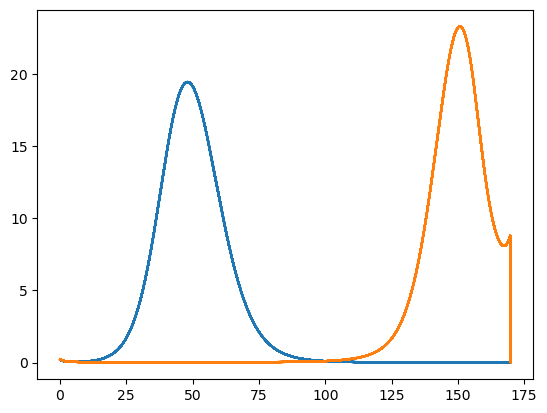

In [136]:
plt.plot(linear_distance, conditional_intensity * sampling_frequency)

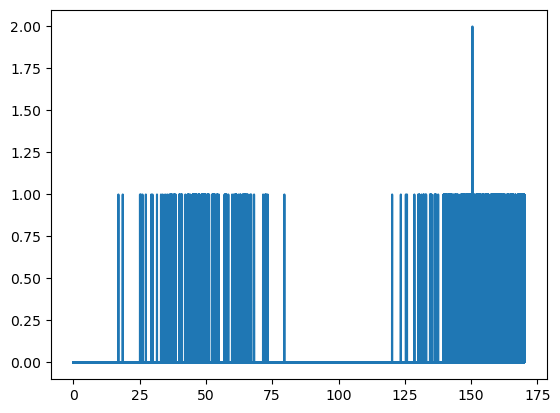

In [127]:
plt.plot(linear_distance, spikes)